# ResNet50 Image Classificiation

This notebook aims to demonstrate the implementation of a ResNet50 model using `tripy`. It implements the architecture, 
loads pretrained weights, and runs predictions on a sample dataset.


## Install Required Libaries

In [1]:
!pip install datasets matplotlib pillow

## Implementation

In [1]:
from typing import Tuple, List

import tripy as tp


class ResNetConvLayer(tp.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        kernel_dims: Tuple[int, int],
        stride: Tuple[int, int] = (1, 1),
        padding: Tuple[Tuple[int, int], Tuple[int, int]] = ((0, 0), (0, 0)),
        activation: bool = True,
    ):
        """Convolutional layer with batch normalization and optional
        ReLU activation."""
        super(ResNetConvLayer, self).__init__()
        self.convolution = tp.Conv(
            in_channels,
            out_channels,
            kernel_dims=kernel_dims,
            stride=stride,
            padding=padding,
            bias=False,
        )
        self.normalization = tp.BatchNorm(out_channels)
        self.activation = activation

    def __call__(self, x: tp.Tensor) -> tp.Tensor:
        x = self.convolution(x)
        x = self.normalization(x)
        if self.activation:
            x = tp.relu(x)
        return x


class ResNetShortCut(tp.Module):
    def __init__(
        self, in_channels: int, out_channels: int, stride: Tuple[int, int]
    ):
        """1x1 convolution and batch normalization for input and output channel
        dimension matching in ResNetBottleNeckLayer."""
        super(ResNetShortCut, self).__init__()
        self.convolution = tp.Conv(
            in_channels,
            out_channels,
            kernel_dims=(1, 1),
            stride=stride,
            bias=False,
        )
        self.normalization = tp.BatchNorm(out_channels)

    def __call__(self, x: tp.Tensor) -> tp.Tensor:
        x = self.convolution(x)
        x = self.normalization(x)
        return x

In [9]:
class ResNetEmbeddings(tp.Module):
    def __init__(self):
        """
        Applies an initial convolution and max-pooling operation to reduce
        dimensions and prepare input for the encoder.
        """
        super(ResNetEmbeddings, self).__init__()
        self.embedder = ResNetConvLayer(
            3,
            64,
            kernel_dims=(7, 7),
            stride=(2, 2),
            padding=((3, 3), (3, 3)),
        )

    def __call__(self, x: tp.Tensor) -> tp.Tensor:
        x = self.embedder(x)
        x = tp.maxpool(
            x,
            kernel_dims=(3, 3),
            stride=(2, 2),
            padding=((1, 1), (1, 1)),
        )
        return x


class ResNetBottleNeckLayer(tp.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        bottleneck_channels: int,
        stride: Tuple[int, int],
    ):
        """Consists of a ResNetShortCut layer for dimension matching and
        three ResNetConvLayers for residual learning."""
        super(ResNetBottleNeckLayer, self).__init__()

        self.shortcut = (
            ResNetShortCut(in_channels, out_channels, stride)
            if in_channels != out_channels or stride != (1, 1)
            else lambda x: x
        )
        self.layer = [
            ResNetConvLayer(
                in_channels,
                bottleneck_channels,
                kernel_dims=(1, 1),
                stride=(1, 1),
            ),
            ResNetConvLayer(
                bottleneck_channels,
                bottleneck_channels,
                kernel_dims=(3, 3),
                stride=stride,
                padding=((1, 1), (1, 1)),
            ),
            ResNetConvLayer(
                bottleneck_channels,
                out_channels,
                kernel_dims=(1, 1),
                stride=(1, 1),
                activation=False,
            ),
        ]

        self.activation = tp.relu

    def __call__(self, x: tp.Tensor) -> tp.Tensor:
        identity = self.shortcut(x)
        for layer in self.layer:
            x = layer(x)
        x = x + identity
        x = self.activation(x)
        return x


class ResNetStage(tp.Module):
    def __init__(
        self,
        num_layers: int,
        in_channels: int,
        out_channels: int,
        bottleneck_channels: int,
        stride: Tuple[int, int],
    ):
        """Contains multiple bottleneck layers, increasing channels and reducing
        spatial dimensions."""
        super(ResNetStage, self).__init__()
        self.layers = []
        for i in range(num_layers):
            layer = ResNetBottleNeckLayer(
                in_channels if i == 0 else out_channels,
                out_channels,
                bottleneck_channels,
                stride if i == 0 else (1, 1),
            )
            self.layers.append(layer)

    def __call__(self, x: tp.Tensor) -> tp.Tensor:
        for layer in self.layers:
            x = layer(x)
        return x


class ResNetEncoder(tp.Module):
    def __init__(
        self, layers_config: List[Tuple[int, int, int, Tuple[int, int]]]
    ):
        """Comprises multiple stages of bottleneck layers to extract abstract
        features from the input."""
        super(ResNetEncoder, self).__init__()
        self.stages = []
        in_channels = 64
        for _, (
            num_layers,
            out_channels,
            bottleneck_channels,
            stride,
        ) in enumerate(layers_config):
            stage = ResNetStage(
                num_layers,
                in_channels,
                out_channels,
                bottleneck_channels,
                stride,
            )
            self.stages.append(stage)
            in_channels = out_channels

    def __call__(self, x: tp.Tensor) -> tp.Tensor:
        for stage in self.stages:
            x = stage(x)
        return x

In [3]:
class ResNetModel(tp.Module):
    def __init__(self):
        """Combines ResNetEmbeddings and ResNetEncoder to create the backbone
        for feature extraction."""
        super(ResNetModel, self).__init__()
        self.embedder = ResNetEmbeddings()
        layers_config = [
            (3, 256, 64, (1, 1)),
            (4, 512, 128, (2, 2)),
            (6, 1024, 256, (2, 2)),
            (3, 2048, 512, (2, 2)),
        ]
        self.encoder = ResNetEncoder(layers_config)

    def __call__(self, x: tp.Tensor) -> tp.Tensor:
        x = self.embedder(x)
        x = self.encoder(x)
        x = tp.avgpool(
            x, kernel_dims=(7, 7), stride=(7, 7)
        )  # output size will be (1, 1)
        return x


class ResNetClassifier(tp.Module):
    def __init__(self, num_classes: int = 1000):
        """Combines the backbone ResNetModel and a classifier head for
        outputting class probabilities."""
        super(ResNetClassifier, self).__init__()
        self.resnet = ResNetModel()
        self.classifier = tp.Sequential(
            lambda x: tp.flatten(x, start_dim=1),
            tp.Linear(2048, num_classes),
        )

    def __call__(self, x: tp.Tensor) -> tp.Tensor:
        features = self.resnet(x)
        return self.classifier(features)

## Instantiate the Model

In [6]:
tripy_model = ResNetClassifier()

## Load Weights to Model

In [7]:
from transformers import ResNetForImageClassification

# Load the pretrained ResNet50 model from Hugging Face
resnet_pretrained = ResNetForImageClassification.from_pretrained(
    "microsoft/resnet-50"
).to("cuda")

In [8]:
def load_pretrained_weights(model, pretrained_state_dict):
    model_state_dict_keys = set(model.state_dict().keys())
    model_dict = {}

    # Convert each weight to a tp.Parameter and update the model's state dict
    for k, v in pretrained_state_dict.items():
        if "num_batches_tracked" in k:
            continue  # Skip num_batches_tracked since it is not needed for
            # inference (tp.BatchNorm does not support)

        assert k in model_state_dict_keys
        model_dict[k] = tp.Parameter(v.contiguous())

    model.load_state_dict(model_dict)


# Load pretrained weights to tripy model
load_pretrained_weights(
    tripy_model,
    pretrained_state_dict=resnet_pretrained.state_dict(),
)

## Compile Model

In [9]:
def resnet_classifier(input):
    """Inference function to compile. Runs forward path
    and returns argmax of output logits."""
    logits = tripy_model(input)
    return tp.argmax(logits) # We compile tp.argmax as well to avoid running it in eager mode.


input_shape = [1, 3, 224, 224]
compiled_resnet_classifier = tp.compile(
    resnet_classifier,
    args=[tp.InputInfo(input_shape, dtype=tp.float32)],
)

## Demo

Now we will test our ResNet50 classification model on a few sample images for image classification task.

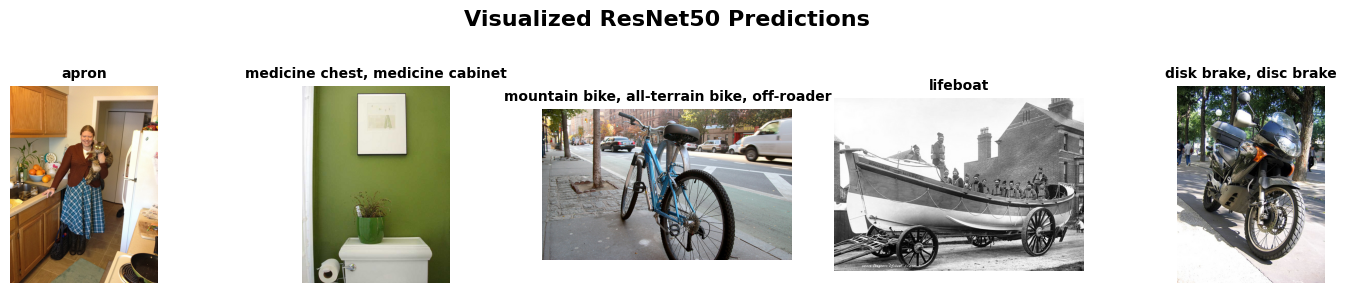

In [15]:
from transformers import AutoImageProcessor
from datasets import load_dataset

import matplotlib.pyplot as plt


# Sample image indices to classify
idxs = [6, 44, 34, 25, 105]
labels = [
    "apron",
    "medicine chest, medicine cabinet",
    "mountain bike, all-terrain bike, off-roader",
    "lifeboat",
    "disk brake, disc brake",
]

# Load the image dataset
dataset = load_dataset("comet-team/coco-500", split="train")

# Load the image processor for image pre-processing
processor = AutoImageProcessor.from_pretrained("microsoft/resnet-50")

fig, axes = plt.subplots(1, len(idxs), figsize=(15, 3))

# Loop through each index and corresponding subplot
for ax, nid, label in zip(axes, idxs, labels):
    image = dataset[nid]["Image"]
    ax.imshow(image)

    # Pre-process the image for inference
    processed_image = processor(image, return_tensors="np")["pixel_values"]
    tp_image = tp.Tensor(
        processed_image,
        dtype=tp.float32,
        device=tp.device("gpu"),
    )

    # Run inference with compiled model and get predicted label
    label_idx = compiled_resnet_classifier(tp_image)
    predicted_label = resnet_pretrained.config.id2label[label_idx.tolist()]

    assert predicted_label == label, f"{predicted_label} vs {label}"
    ax.set_title(predicted_label, fontsize=10, fontweight="bold")
    ax.axis("off")
    ax.set_xticks([])
    ax.set_yticks([])


plt.tight_layout(pad=3.0)
plt.suptitle(
    "Visualized ResNet50 Predictions",
    fontsize=16,
    fontweight="bold",
    y=1.05,
)
plt.show()